# 5. Predicting goal with multiple classifiers

---
**To be able to execute this notebook, please download your own local version of the data from https://www.kaggle.com/martinellis/nhl-game-data and store it into the folder "data/nhl/nhl_stats/"**


---

After first feature modelling and evaluation of the model using logistic regression, some new classifiers and some other metrics will be considered.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import time

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
from matplotlib import patches

from utils import create_dummy_df
from utils import plot_correlation_matrix
from utils import balance_binary_target

from metrics import save_metrics
from metrics import plot_metrics
from metrics import init_metrics_file


from models import run_logistic_regression
from models import run_lightgbm_classifier
from models import run_kneighbors_classifier

sns.set()

---
## Preparing data used in the previous sections

In [2]:
# read data
df_game_plays = pd.read_csv('data/nhl/nhl_stats/game_plays.csv')

# drop NaNs, select relevant columns only
df = df_game_plays[['play_id', 'event', 'secondaryType', 'st_x', 'st_y']][(df_game_plays.event=='Goal') | (df_game_plays.event=='Shot')]
df.dropna(inplace=True)
df.secondaryType = df.secondaryType.str.replace(" ", "")
df.secondaryType = df.secondaryType.str.replace("-", "")

# Prepare target. Convert categorical event values 'Goal' to a numerical 0/1 value indicating goal
df['goal'] = np.where(df.event=='Goal', 1, 0)
df.drop(columns='event', inplace=True)

# Convert categorical 'secondaryType' column to multiple numerical columns
cat_cols = ['secondaryType']
df = create_dummy_df(df=df, cat_cols=cat_cols, dummy_na=True)
df.drop(columns=['secondaryType_nan'], inplace=True)
df.head()

,play_id,st_x,st_y,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot
4,2016020045_5,71.0,-9.0,0,0,0,0,0,0,1
5,2016020045_6,88.0,-5.0,1,0,0,0,0,1,0
7,2016020045_8,56.0,-7.0,0,0,0,0,0,0,1
11,2016020045_12,37.0,24.0,0,0,1,0,0,0,0
16,2016020045_17,57.0,-20.0,0,0,0,0,0,0,1


In [3]:
# save prepared data
df_data = df.copy()

---
### Using data in the goal prediction

The models are going to be used for different expriments. In order to not the repeat the code, the implementation has been encapsulate in the file *models.py*,
implementing following functions for three different classifiers:

* run_logistic_regression
* run_lightgbm_classifier
* run_kneighbors_classifier

---
In addition to the accuracy score, F1 score and the confusion matrix, the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the AUC-ROC (ared under (ROC) curve) will be evaluated. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The ROC space is defined as followed ([source](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#/media/File:ROC_space-2.png)) :

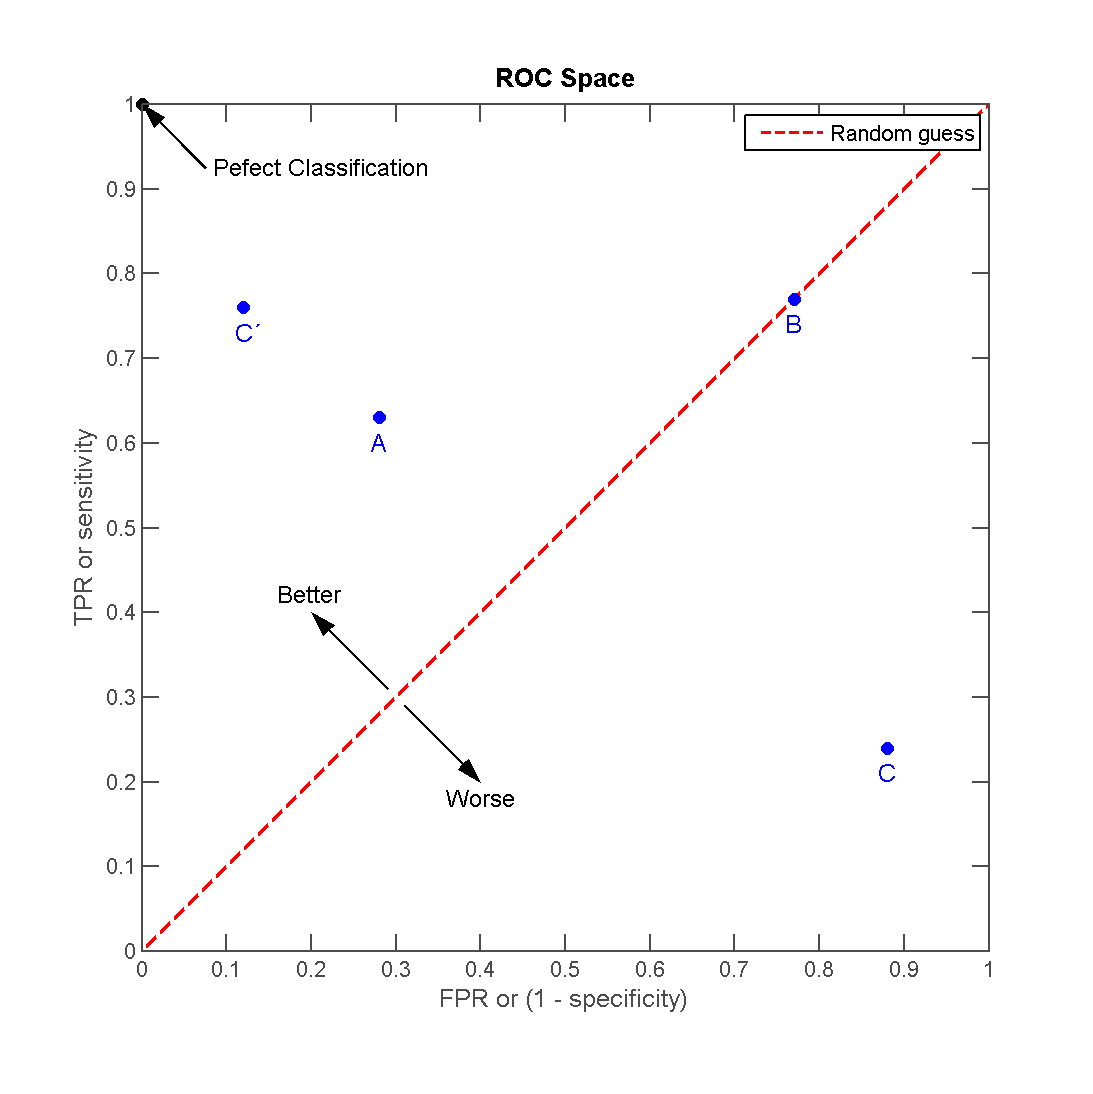

In [4]:
Image(filename='data/images/ROC_space-2.png', width=400, ) #https://en.wikipedia.org/wiki/Receiver_operating_characteristic#/media/File:ROC_space-2.png

---
For each of evaluated classifiers, all metrics will be calculated and the confusion matrix and the ROC curce will be plotted:

========== Logistic Regression ==========
Accuracy: 0.9060
F1 Score: 0.0000
AUC-ROC Score: 0.6659
-----------------------------------------
Precision: 0.0000
Recall: 0.0000


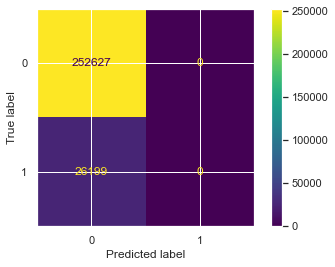

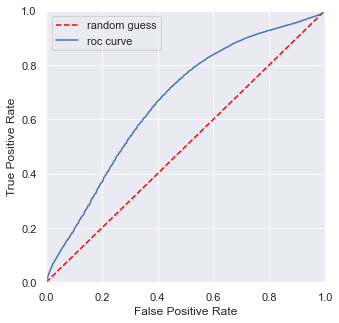

In [5]:
# === Logistic Regression ===
_, lg = run_logistic_regression(df_data);
save_metrics('1_unbalanced', metrics_lg=lg)

========== LightGBM Classifier ==========
Accuracy: 0.9061
F1 Score: 0.0054
AUC-ROC Score: 0.7353
-----------------------------------------
Precision: 0.6228
Recall: 0.0027


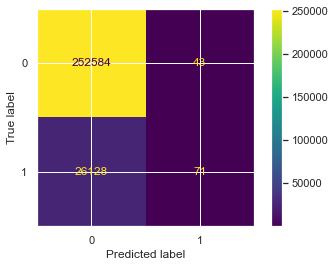

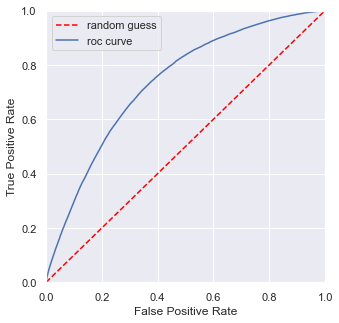

In [6]:
# === LightGBM Classifier ===
_, lgbm = run_lightgbm_classifier(df_data);
save_metrics('1_unbalanced', metrics_lgbm=lgbm)

========= KNeighbors Classifier =========
Accuracy: 0.9061
F1 Score: 0.0030
AUC-ROC Score: 0.7211
-----------------------------------------
Precision: 0.5652
Recall: 0.0015


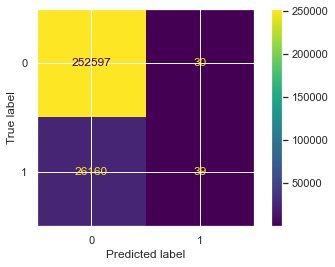

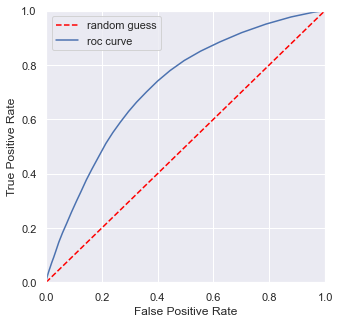

In [7]:
# === KNeighbors Classifier ===
_, knc = run_kneighbors_classifier(df_data);
save_metrics('1_unbalanced', metrics_knc=knc)

---

This training was done using the unbalanced dataset having too many target goal=0 compared to 1. As visible on the values and the plots, this is a huge problem for the logistic regression. It made NO prediction of a successful goal. Also the ROC curve was very flat and close to the *random guess* line. That's why the AUC value (**0.67**) for logistic regression was lower compared to others.

LightGBM and KNeighbors did a bit better even with non balanced dataset. They were able to predict at least some positive value of the target goal. F1 Score was close to the 0 but not equal 0. Also the value of the AUC metric was higher than the one of the logistic regression. It was **0.74** and **0.72**. 

The conclusion is that the logistic regression can't deal with unbalansed dataset compared to the others. However, there is still the possibility to differently weight particular target values in order to fix this dataset bias. This is what happens as next:

In [8]:
# calculate ratio of 0 vs. 1 target
print(f'Number of 0s in the target: {df_data[df_data.goal == 0].shape[0]}, which is {df_data[df_data.goal == 0].shape[0]/df_data.shape[0]*100:.2f}%')
print(f'Number of 1s in the target: {df_data[df_data.goal == 1].shape[0]}, which is {df_data[df_data.goal == 1].shape[0]/df_data.shape[0]*100:.2f}%')

Number of 0s in the target: 842232, which is 90.62%
Number of 1s in the target: 87187, which is 9.38%


---
Comparing for logistic regression:

========== Logistic Regression ==========
Accuracy: 0.9060
F1 Score: 0.0000
AUC-ROC Score: 0.6659
-----------------------------------------
Precision: 0.0000
Recall: 0.0000
========== Logistic Regression ==========
Accuracy: 0.5702
F1 Score: 0.2376
AUC-ROC Score: 0.6646
-----------------------------------------
Precision: 0.1425
Recall: 0.7128


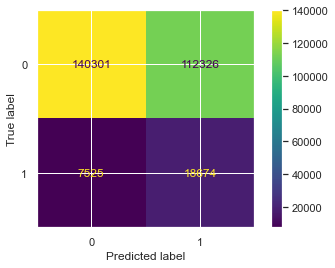

In [9]:
# repeat logistic regressin with and without using the weights

run_logistic_regression(df_data, conf_matrix=False, roc_curve=False);
_, lg = run_logistic_regression(df_data, balance_weights=True, conf_matrix=True, roc_curve=False);
save_metrics('2_weighted', metrics_lg=lg)

The F1 Score is better now but the number of Type I error (false positives) is very high. Even with explizit weights, logistic regression can't handle this problem.

---
Comparing for LightGBM:

========== LightGBM Classifier ==========
Accuracy: 0.9061
F1 Score: 0.0054
AUC-ROC Score: 0.7353
-----------------------------------------
Precision: 0.6228
Recall: 0.0027
========== LightGBM Classifier ==========
Accuracy: 0.6457
F1 Score: 0.2772
AUC-ROC Score: 0.7354
-----------------------------------------
Precision: 0.1715
Recall: 0.7231


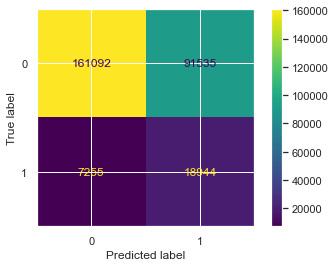

In [10]:
# in order to optimize the LGBM, unbalanced flag will be set
run_lightgbm_classifier(df_data, conf_matrix=False, roc_curve=False);
_, lgbm = run_lightgbm_classifier(df_data, unbalanced=True, conf_matrix=True, roc_curve=False);
save_metrics('2_weighted', metrics_lgbm=lgbm)

Very similar result here. Increase of F1 score but still too many Type I errors (false positives).

---
Small inprovements, not really much, we need to balance the dataset. There are 87187 positive targets in the dataset. If I add a sample of another 87187 negative prediction, we can get the balance and re-train the models again:

### Balance the dataset again - similar like I did in the previous notebook

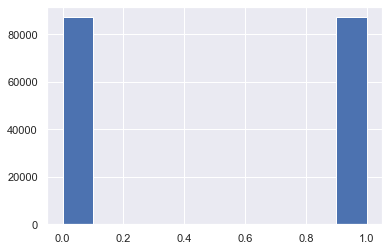

In [11]:
# using a function from utils.py to balance the target
df_balanced = balance_binary_target(df_data, target='goal')
df_balanced.goal.hist();

========== Logistic Regression ==========
Accuracy: 0.6294
F1 Score: 0.6537
AUC-ROC Score: 0.6588
-----------------------------------------
Precision: 0.6113
Recall: 0.7025


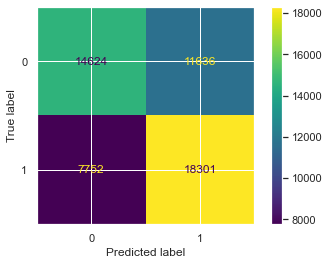

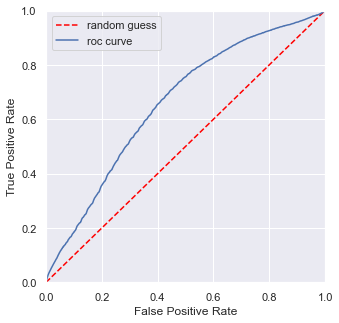

========== LightGBM Classifier ==========
Accuracy: 0.6755
F1 Score: 0.6897
AUC-ROC Score: 0.7334
-----------------------------------------
Precision: 0.6584
Recall: 0.7241


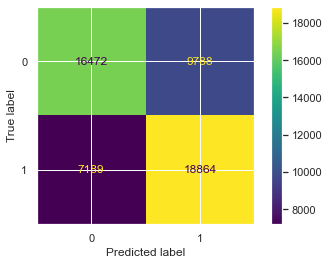

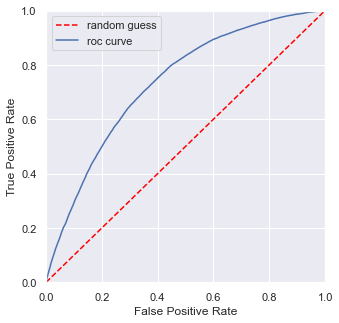

========= KNeighbors Classifier =========
Accuracy: 0.6710
F1 Score: 0.6793
AUC-ROC Score: 0.7225
-----------------------------------------
Precision: 0.6601
Recall: 0.6997


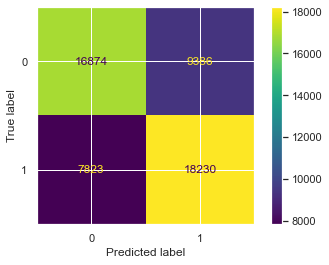

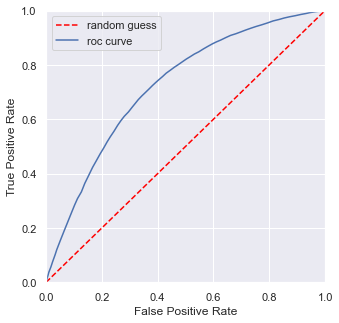

In [12]:
# starting training again
_, lg = run_logistic_regression(df_balanced);
_, lgbm = run_lightgbm_classifier(df_balanced);
_, knc = run_kneighbors_classifier(df_balanced);
save_metrics('3_balanced', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

Balancing the targets in the dataset boosted the F1 score to values around **0.68** still keeping the AUC value high. 

---

## Use the new features distance modelled in previous sections:

In the first step, we can visualize some data to get a good intuition how to calculate the distance from *st_x* and *st_y*.

In [13]:
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)

df_data_dist = df_balanced.copy()
df_data_dist['distance'] = df_data_dist.apply(dist, axis=1)

# cut outliers first
df_data_dist = df_data_dist[df_data_dist.distance<50]

---
### Re-train and evaluate the models

#### Without distance

In [14]:
# starting training again
run_logistic_regression(df_balanced, conf_matrix=False, roc_curve=False);
run_lightgbm_classifier(df_balanced, conf_matrix=False, roc_curve=False);
run_kneighbors_classifier(df_balanced, conf_matrix=False, roc_curve=False);

========== Logistic Regression ==========
Accuracy: 0.6294
F1 Score: 0.6537
AUC-ROC Score: 0.6588
-----------------------------------------
Precision: 0.6113
Recall: 0.7025
========== LightGBM Classifier ==========
Accuracy: 0.6755
F1 Score: 0.6897
AUC-ROC Score: 0.7334
-----------------------------------------
Precision: 0.6584
Recall: 0.7241
========= KNeighbors Classifier =========
Accuracy: 0.6710
F1 Score: 0.6793
AUC-ROC Score: 0.7225
-----------------------------------------
Precision: 0.6601
Recall: 0.6997


### With distance

In [15]:
# starting training again
_, lg = run_logistic_regression(df_data_dist, conf_matrix=False, roc_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_dist, conf_matrix=False, roc_curve=False);
_, knc = run_kneighbors_classifier(df_data_dist, conf_matrix=False, roc_curve=False);

save_metrics('4_with_distance', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

========== Logistic Regression ==========
Accuracy: 0.6547
F1 Score: 0.7443
AUC-ROC Score: 0.6716
-----------------------------------------
Precision: 0.6601
Recall: 0.8533
========== LightGBM Classifier ==========
Accuracy: 0.6626
F1 Score: 0.7457
AUC-ROC Score: 0.6820
-----------------------------------------
Precision: 0.6707
Recall: 0.8394
========= KNeighbors Classifier =========
Accuracy: 0.6486
F1 Score: 0.7289
AUC-ROC Score: 0.6673
-----------------------------------------
Precision: 0.6680
Recall: 0.8020


The feature distance improved the F1 Score of all model. It slightly descreased the values of AUC for LGBM anf KNC.

## Use the new features angle 

Similar to the distance feature, let's use angle 

In [16]:
def angle(df):     
    middle_goal_x = 100 
    return math.fabs(math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90)
#    return math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90

df_data_dist_angle = df_data_dist.copy()
df_data_dist_angle['angle'] = df_data_dist_angle.apply(angle, axis=1)

# cutting outliers
df_data_dist_angle= df_data_dist_angle[df_data_dist_angle.angle<40]

#### re-train models

In [17]:
# starting training again
_, lg = run_logistic_regression(df_data_dist_angle, conf_matrix=False, roc_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_dist_angle, conf_matrix=False, roc_curve=False);
_, knc = run_kneighbors_classifier(df_data_dist_angle, conf_matrix=False, roc_curve=False);

save_metrics('5_with_angle', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

========== Logistic Regression ==========
Accuracy: 0.6513
F1 Score: 0.7542
AUC-ROC Score: 0.6420
-----------------------------------------
Precision: 0.6718
Recall: 0.8596
========== LightGBM Classifier ==========
Accuracy: 0.6531
F1 Score: 0.7570
AUC-ROC Score: 0.6441
-----------------------------------------
Precision: 0.6709
Recall: 0.8685
========= KNeighbors Classifier =========
Accuracy: 0.6400
F1 Score: 0.7436
AUC-ROC Score: 0.6287
-----------------------------------------
Precision: 0.6677
Recall: 0.8390


There was not really and improvement in the model. The values are more or less same.

---
Feature importance investigation could provide an answer why.

### Look at the feature importance

========== LightGBM Classifier ==========
Accuracy: 0.6531
F1 Score: 0.7570
AUC-ROC Score: 0.6441
-----------------------------------------
Precision: 0.6709
Recall: 0.8685


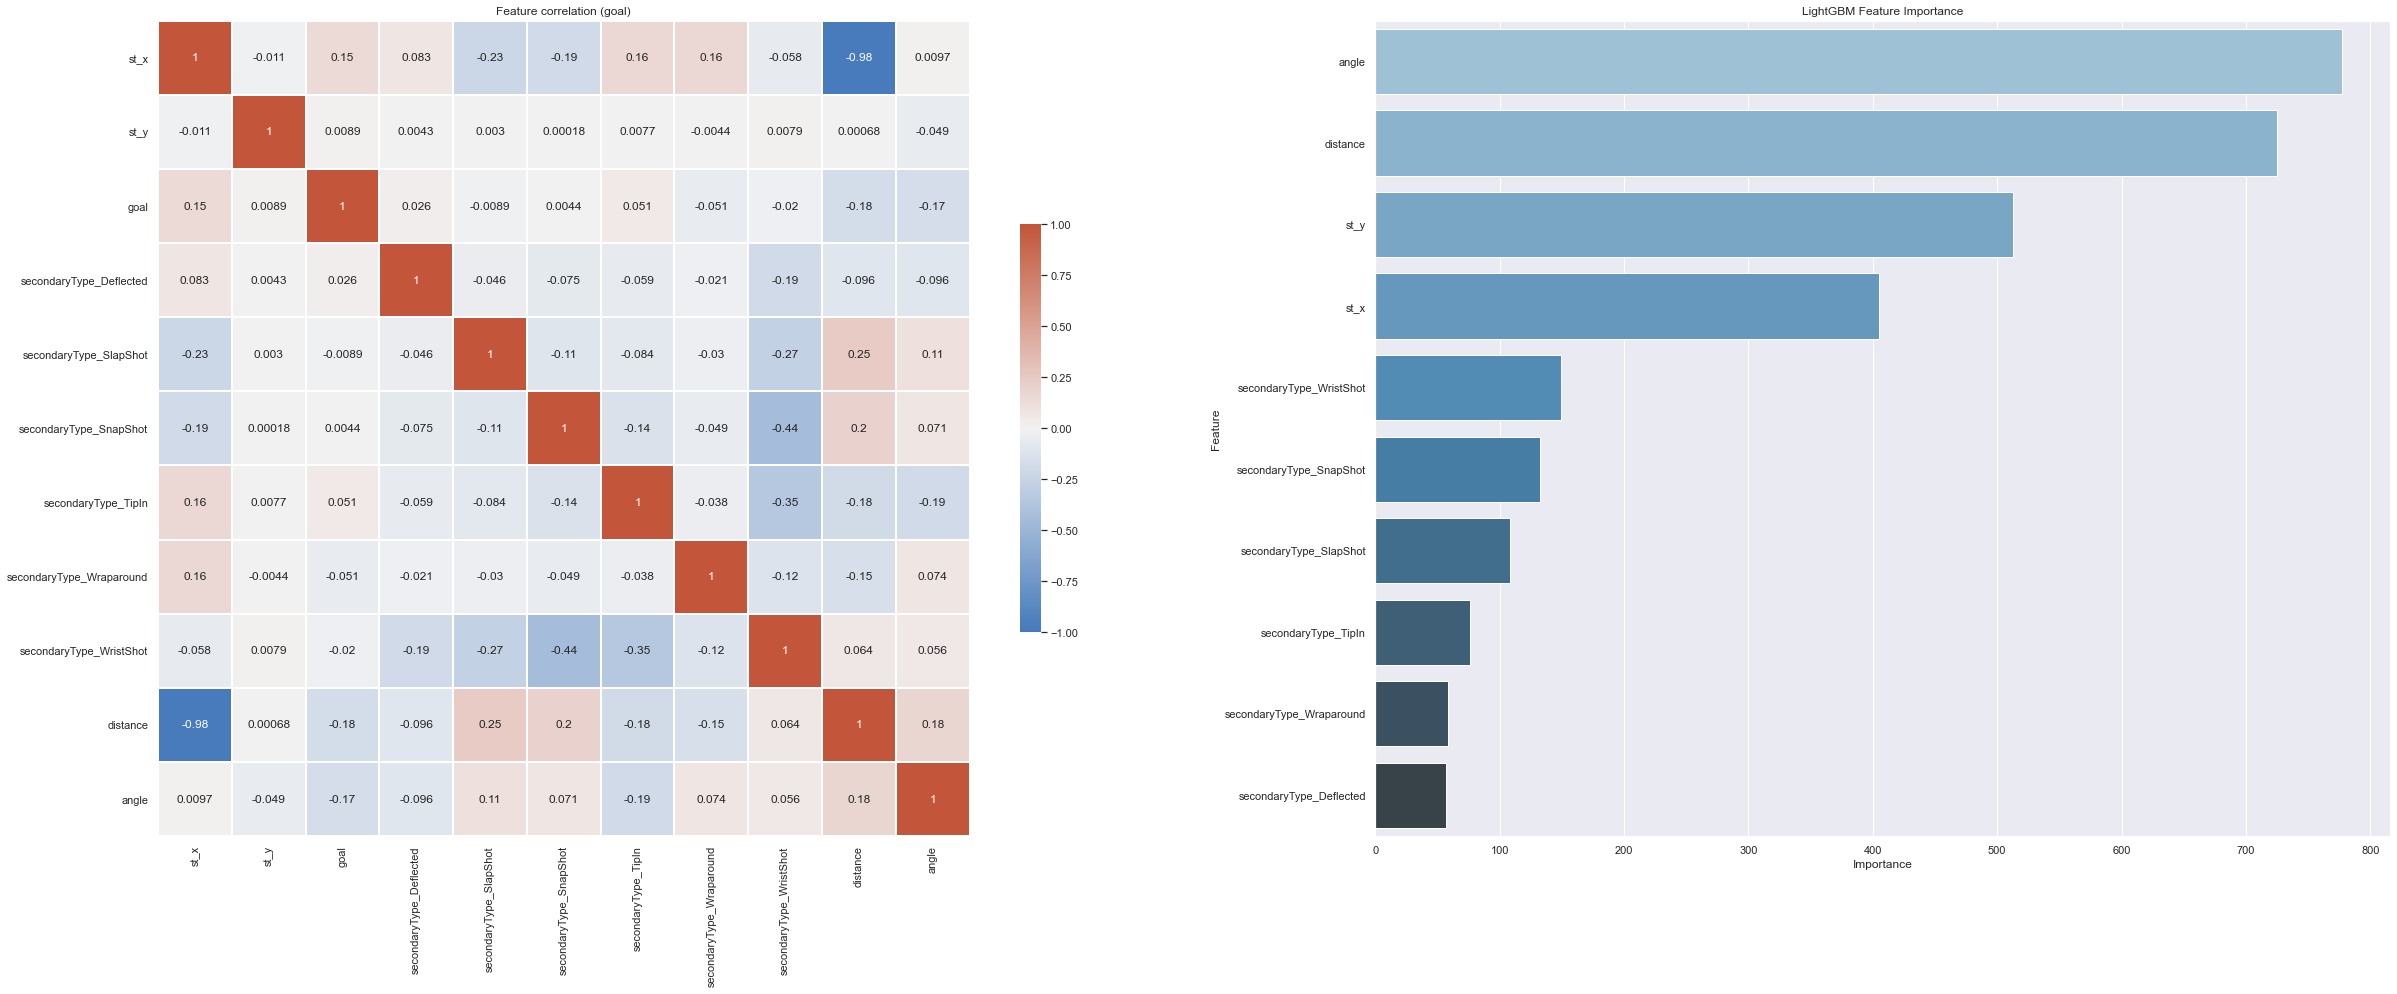

In [18]:
features = df_data_dist_angle.select_dtypes(exclude='object').columns.to_list()
features.remove('goal')

target = 'goal'

lgbm_model, _ = run_lightgbm_classifier(df_data_dist_angle, features=features, target=target, conf_matrix=False, roc_curve=False);


col='goal'
corr = df_data_dist_angle.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.subplots(1, 2, figsize=(40, 15))
plt.subplot(121)

plt.title('Feature correlation (goal)')
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});

plt.subplot(122)
feature_imp = pd.DataFrame({'Importance':lgbm_model.feature_importances_,'Feature':features})
sns.barplot(x="Importance", y="Feature", palette='Blues_d', data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.show()

---
Feature *angle* is not really correlated with the *goal*. It the feature importance of the LGBM model, the most important feature in the distance. *Angle* is the second important together with *st_y*. *angle* and *st_y* are strongly correlated and *st_y* was is the model before. That's why *angle* doesn't really caused a performace increase.

---